# IntroML 2024 Spring. NLP part 1

**Выполнил: Борисочкин Михаил ML-12**

## Условие задачи

Участникам предоставлен набор данных, содержащий url и title веб-страниц, а также метку класса - 1, если страница относится к контенту 18+ и 0 - не относится к контенту 18+.

Задача состоит в том, чтобы на основе предоставленного набора тренировочных данных построить бинарный классификатор веб-страниц.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer

import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

%matplotlib inline
sns.set(style="ticks")

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Михаил\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Михаил\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Загрузка датасетов

In [2]:
# Загрузка обучающего набора данных
train_df = pd.read_csv("data/train.csv")
train_df.sample(10, random_state=1)

,ID,url,title,label
17197,17197,24video.live,Видео: Молодые �� Выстрелы �� спермы Минет �� ...,1
9632,9632,www.cellmat.ru,Автоковрики для Mitsubishi Pajero Sport 🚗 - ку...,0
125814,125814,ekapusta.com,Личный кабинет,0
112211,112211,m.unegui.mn,"Alphardiin ruliin apparat hybrid 10,000 ₮ №197...",0
34750,34750,gmologsu.ucoz.ru,Сайт ГМО логопедов Североуральска - Главная ст...,0
16509,16509,m.rusex-club.me,Любовник обнимает маленькую попку своей телки ...,1
106472,106472,www.bolshoyvopros.ru,Какая рыба лучше всего подходит для жарки на к...,0
17317,17317,nominal.club,"Россия 2 рубля 2019 год - Поэт Мустай Карим, к...",0
116296,116296,www.kufar.by,Коляска Camarelo sport,0
122073,122073,ekaterinburg.n1.ru,Объявление №31425732 - аренда помещения в Екат...,0


In [3]:
# Загрузка тестового набора данных
test_df = pd.read_csv("data/test.csv")
test_df.head()

,ID,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


## Разведочный анализ и предобработка данных

In [4]:
# Количество пустых значений
train_df.isnull().sum()

ID       0
url      0
title    1
label    0
dtype: int64

In [5]:
# Удаление пустых значений
train_df = train_df.dropna(axis=0)
train_df.isnull().sum()

ID       0
url      0
title    0
label    0
dtype: int64

In [6]:
# Количество дублирующихся значений
train_df.duplicated().sum()

0

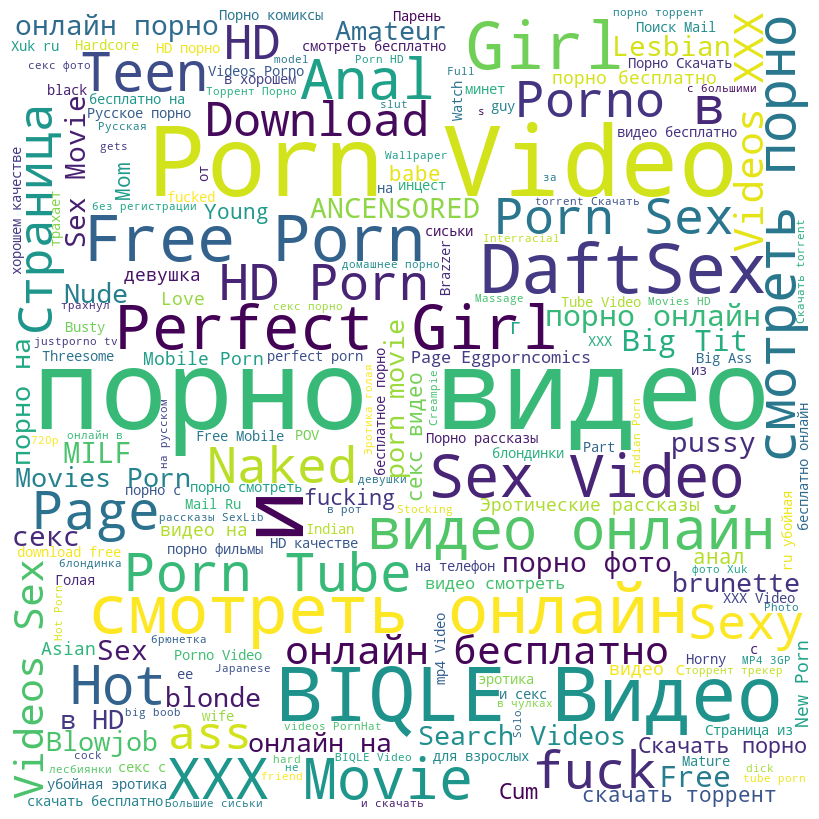

In [7]:
# Облако слов, связанных с контентом 18+
bad_words = ""

for text in train_df[train_df.label == 1].title:
    bad_words += text + " "

wordcloud = WordCloud(
    width=800, height=800, background_color="white", min_font_size=10
).generate(bad_words)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

Из облака слов видно, что в тексте контента 18+ часто попадаются союзы (и, в, на и т. п.). Очистим title от стоп-слов, знаков пунктуации, цифр, а также проведём лемматизацию.

In [8]:
# Загрузка стоп-слов и инициализация лемматизатора
stop_words = set(stopwords.words("english") + stopwords.words("russian"))
morph = MorphAnalyzer()

In [9]:
def text_preprocessing(text):
    """
    Функция предобработки текста (lower-case + удаление знаков препинания, цифр и стоп-слов + лемматизация)
    :param text: текст
    :return: очищенный текст
    """
    # Lower-case
    res = text.lower()

    # Удаление знаков препинания и цифр
    translator = str.maketrans("", "", string.punctuation + string.digits + "№")
    res = res.translate(translator)

    # Удаление стоп-слов
    word_tokens = word_tokenize(res, language="russian")

    # Лемматизация
    filtered_text = [
        morph.parse(word)[0].normal_form
        for word in word_tokens
        if word not in stop_words
    ]

    return " ".join(filtered_text)

In [10]:
# Проверка работы функции предобработки функции
text_preprocessing("Проверка работы функции! А вот это test of this function")

'проверка работа функция это test function'

In [11]:
# Применение функции предобработки текста
preprocessed_df = train_df.copy()
preprocessed_df.title = preprocessed_df.title.apply(text_preprocessing)
preprocessed_df.sample(10, random_state=1)

,ID,url,title,label
17197,17197,24video.live,видео молодой �� выстрел �� сперма минуть �� c...,1
9632,9632,www.cellmat.ru,автоковрик mitsubishi pajero sport 🚗 купить са...,0
114737,114737,mail.ru,знакомстваmailru — алексей филат украина донец...,0
112211,112211,m.unegui.mn,alphardiin ruliin apparat hybrid ₮ улаанбаатар...,0
34750,34750,gmologsu.ucoz.ru,сайт гмо логопед североуральск главный страница,0
16509,16509,m.rusex-club.me,любовник обнимать маленький попка свой тёлка т...,1
106472,106472,www.bolshoyvopros.ru,рыба подходить жарка костёр,0
17317,17317,nominal.club,россия рубль год поэт мустая карим летие день ...,0
116296,116296,www.kufar.by,коляска camarelo sport,0
122073,122073,ekaterinburg.n1.ru,объявление аренда помещение екатеринбург киров...,0


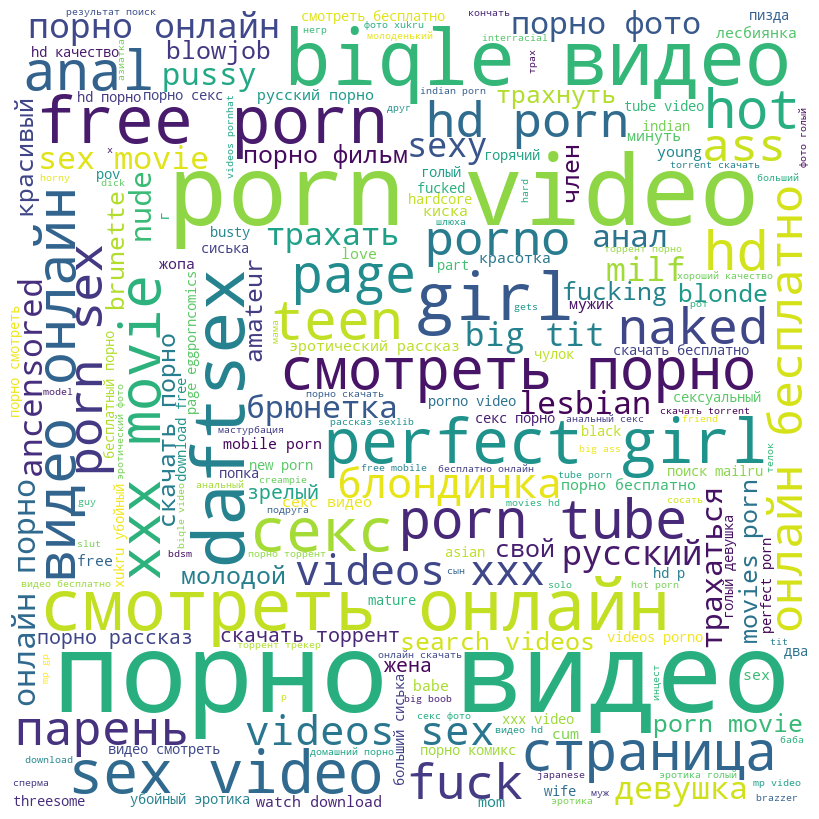

In [12]:
# Облако слов, связанных с контентом 18+ после обработки текста
bad_words = ""

for text in preprocessed_df[train_df.label == 1].title:
    bad_words += text + " "

wordcloud = WordCloud(
    width=800, height=800, background_color="white", min_font_size=10
).generate(bad_words)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

Создадим новое поле text, которое будет представлять собой комбинацию url-а и title-а. Данное поле будет использоваться для дальнейшей классификации. Предполагается, что качество классификации будет выше, чем если бы мы классифицировали по полю title

In [13]:
# Создание нового поля text
preprocessed_df["text"] = preprocessed_df["url"] + " " + preprocessed_df["title"]
preprocessed_df.head(10)

,ID,url,title,label,text
0,0,m.kp.md,эксминистр экономика молдова глава мидэя цель ...,0,m.kp.md эксминистр экономика молдова глава мид...
1,1,www.kp.by,этот песня стать известный многий телезритель ...,0,www.kp.by этот песня стать известный многий те...
2,2,fanserials.tv,банша сезон серия бремя красота смотреть онлайн,0,fanserials.tv банша сезон серия бремя красота ...
3,3,colorbox.spb.ru,бесить картинка,0,colorbox.spb.ru бесить картинка
4,4,tula-sport.ru,новомосковск сыграть следжхоккеист алексинский...,0,tula-sport.ru новомосковск сыграть следжхоккеи...
5,5,beregifiguru.ru,салат корейский морковь копчёный курица кукуру...,0,beregifiguru.ru салат корейский морковь копчён...
6,6,ekb.vseinstrumenti.ru,угловой пневмогайковерт fubag rwc екатеринбург...,0,ekb.vseinstrumenti.ru угловой пневмогайковерт ...
7,7,mirtabaka.org,табачный магазин мир табак курительный трубка ...,0,mirtabaka.org табачный магазин мир табак курит...
8,8,xlecx.com,league legends » page » porn comics free online,1,xlecx.com league legends » page » porn comics ...
9,9,bus.biletyplus.ua,р одесса ростовнадон сентябрь фаворит чп,0,bus.biletyplus.ua р одесса ростовнадон сентябр...


## Разделение на обучающую и валидационную выборки

In [14]:
# Разделение на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_df.text,
    preprocessed_df.label,
    test_size=0.1,
    random_state=1,
    stratify=preprocessed_df.label,
)

In [15]:
# Размер обучающей выборки
X_train.shape

(121777,)

In [16]:
# Размер валидационной выборки
X_test.shape

(13531,)

In [17]:
# Количество экземпляров каждого класса в обучающей выборки
y_train.value_counts()

label
0    106734
1     15043
Name: count, dtype: int64

In [18]:
# Количество экземпляров каждого класса в валидационной выборки
y_test.value_counts()

label
0    11859
1     1672
Name: count, dtype: int64

Судя по количеству меток в выборках начальный набор данных несбалансированный

## Обучение модели

Для классификации контента 18+ будем использовать связку TF-IDF + SVM.

Если про TF-IDF рассказывалось на лекции, то про SVM — нет.

SVM (метод опорных векторов, машина опорных векторов) — один из наиболее популярных методов обучения, который применяется для решения задач классификации и регрессии. Основная идея метода заключается в построении гиперплоскости, разделяющей объекты выборки оптимальным способом. Алгоритм работает в предположении, что чем больше расстояние (зазор) между разделяющей гиперплоскостью и объектами разделяемых классов, тем меньше будет средняя ошибка классификатора.

Подробнее [тут](https://habr.com/ru/articles/428503/).

Для решения нашей задачи будем использовать классификатор на основе метода опорных векторов с линейным ядром. Данный классификатор в scikit-learn реализован в виде класса [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

In [19]:
# Создание модели
clf_SVC = Pipeline(
    [
        ("TF-IDF", TfidfVectorizer()),
        ("SVC", LinearSVC(dual="auto", C=2.5, random_state=42)),
    ]
)

In [20]:
%%time
# Обучение модели
clf_SVC.fit(X_train, y_train)

CPU times: total: 625 ms
Wall time: 2.01 s


Pipeline(steps=[('TF-IDF', TfidfVectorizer()),
                ('SVC', LinearSVC(C=2.5, dual='auto', random_state=42))])

In [21]:
%%time
# Получение предсказаний
y_pred = clf_SVC.predict(X_test)

CPU times: total: 15.6 ms
Wall time: 141 ms


In [22]:
# Вывод отчёта о классификации
print(
    classification_report(
        y_test, y_pred, target_names=["Обычный контент", "Контент 18+"]
    )
)

                 precision    recall  f1-score   support

Обычный контент       1.00      1.00      1.00     11859
    Контент 18+       0.99      0.97      0.98      1672

       accuracy                           1.00     13531
      macro avg       0.99      0.98      0.99     13531
   weighted avg       1.00      1.00      1.00     13531



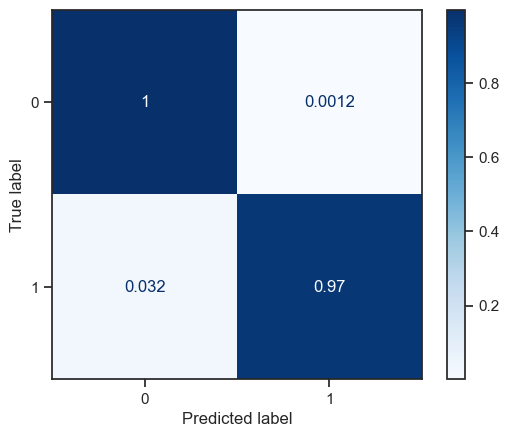

In [23]:
# Вывод матрицы ошибок
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", normalize="true")
plt.show()

In [24]:
# Значение f1-меры
f1_score(y_test, y_pred)

0.9797276853252648

### Подбор гиперпараметров

In [25]:
# Гиперпараметры для оптимизации
params = {
    "TF-IDF__min_df": [1, 2, 3],
    "TF-IDF__max_df": [0.6, 0.8, 1.0],
    "SVC__C": np.linspace(1, 3, 5),
}

In [26]:
grid_search = GridSearchCV(clf_SVC, params, cv=5, n_jobs=-1, scoring="f1", verbose=3)

In [27]:
%%time
# Поиск лучших гиперпараметров
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
CPU times: total: 25.7 s
Wall time: 51.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TF-IDF', TfidfVectorizer()),
                                       ('SVC',
                                        LinearSVC(C=2.5, dual='auto',
                                                  random_state=42))]),
             n_jobs=-1,
             param_grid={'SVC__C': array([1. , 1.5, 2. , 2.5, 3. ]),
                         'TF-IDF__max_df': [0.6, 0.8, 1.0],
                         'TF-IDF__min_df': [1, 2, 3]},
             scoring='f1', verbose=3)

In [28]:
# Лучшие значения параметров
grid_search.best_params_

{'SVC__C': 2.0, 'TF-IDF__max_df': 0.6, 'TF-IDF__min_df': 1}

In [29]:
# Лучшая f-мера
grid_search.best_score_

0.9764632822936606

In [30]:
# Лучший классификатор
grid_search.best_estimator_

Pipeline(steps=[('TF-IDF', TfidfVectorizer(max_df=0.6)),
                ('SVC', LinearSVC(C=2.0, dual='auto', random_state=42))])

In [31]:
best_clf = grid_search.best_estimator_

In [32]:
%%time
# Получение предсказаний
y_pred_best = best_clf.predict(X_test)

CPU times: total: 0 ns
Wall time: 133 ms


In [33]:
# Вывод отчёта о классификации
print(
    classification_report(
        y_test, y_pred_best, target_names=["Обычный контент", "Контент 18+"]
    )
)

                 precision    recall  f1-score   support

Обычный контент       1.00      1.00      1.00     11859
    Контент 18+       0.99      0.97      0.98      1672

       accuracy                           0.99     13531
      macro avg       0.99      0.98      0.99     13531
   weighted avg       0.99      0.99      0.99     13531



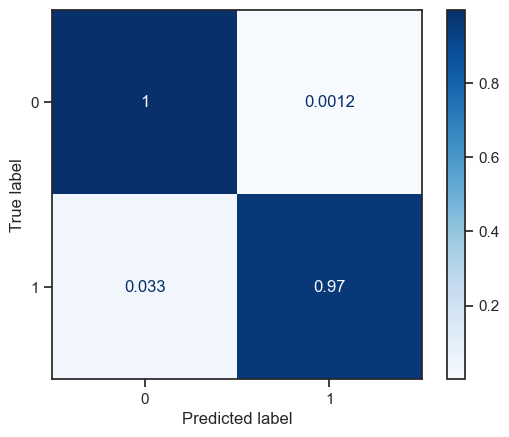

In [34]:
# Вывод матрицы ошибок
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best, cmap="Blues", normalize="true"
)
plt.show()

In [35]:
# Значение f1-меры
f1_score(y_test, y_pred_best)

0.9788007268322229

## Другая модель

В качестве другой модели возьмём [случайный лес](https://neerc.ifmo.ru/wiki/index.php?title=%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%BE_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9_%D0%B8_%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9_%D0%BB%D0%B5%D1%81)

Случайный лес является ансамблевой моделью и представляет собой алгоритм бэггинга над решающими деревьями.

In [36]:
# Создание модели
clf_RF = Pipeline(
    [
        ("TF-IDF", TfidfVectorizer(max_df=0.6)),
        ("RF", RandomForestClassifier(n_estimators=100, random_state=42)),
    ]
)

In [37]:
%%time
# Обучение модели
clf_RF.fit(X_train, y_train)

CPU times: total: 27.5 s
Wall time: 3min


Pipeline(steps=[('TF-IDF', TfidfVectorizer(max_df=0.6)),
                ('RF', RandomForestClassifier(random_state=42))])

In [38]:
%%time
# Получение предсказаний
y_pred = clf_RF.predict(X_test)

CPU times: total: 312 ms
Wall time: 1.93 s


In [39]:
# Вывод отчёта о классификации
print(
    classification_report(
        y_test, y_pred, target_names=["Обычный контент", "Контент 18+"]
    )
)

                 precision    recall  f1-score   support

Обычный контент       1.00      1.00      1.00     11859
    Контент 18+       0.99      0.97      0.98      1672

       accuracy                           0.99     13531
      macro avg       0.99      0.98      0.99     13531
   weighted avg       0.99      0.99      0.99     13531



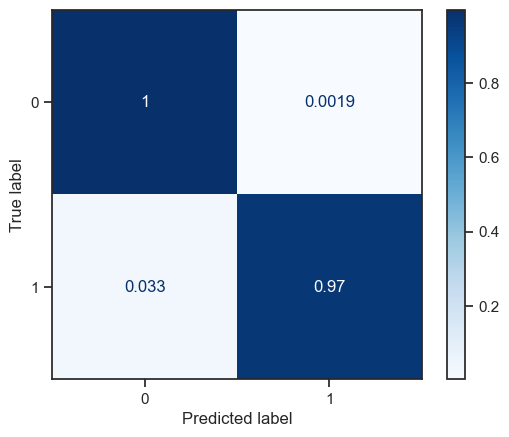

In [40]:
# Вывод матрицы ошибок
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", normalize="true")
plt.show()

In [41]:
# Значение f1-меры
f1_score(y_test, y_pred)

0.9767441860465116

## Стекинг

Попробуем улучшить качество классификации "застекав" предыдущие модели.

[Стекинг](https://alexanderdyakonov.wordpress.com/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/) представляет собой обучение нескольких базовых алгоритмов, 
обучение метаалгоритма на их выводе. Данный подход позволяет улучшить качество предсказаний.

В качестве базовых моделей в нашем случае будут машина опорных векторов и случайный лес, а в качестве метаалгоритма — логистическая регрессия.

In [42]:
estimators = [
    ("SVC", LinearSVC(C=2.5, dual="auto", random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=100, random_state=42)),
]

stacking_clf = Pipeline(
    [
        ("TF-IDF", TfidfVectorizer(max_df=0.6)),
        (
            "Stacking",
            StackingClassifier(
                estimators=estimators,
                final_estimator=LogisticRegression(solver="liblinear", random_state=42),
                cv=3,
            ),
        ),
    ]
)

In [43]:
%%time
# Обучение модели
stacking_clf.fit(X_train, y_train)

CPU times: total: 7min 54s
Wall time: 42min


Pipeline(steps=[('TF-IDF', TfidfVectorizer(max_df=0.6)),
                ('Stacking',
                 StackingClassifier(cv=3,
                                    estimators=[('SVC',
                                                 LinearSVC(C=2.5, dual='auto',
                                                           random_state=42)),
                                                ('RF',
                                                 RandomForestClassifier(random_state=42))],
                                    final_estimator=LogisticRegression(random_state=42,
                                                                       solver='liblinear')))])

In [44]:
%%time
# Получение предсказаний
y_pred = stacking_clf.predict(X_test)

CPU times: total: 219 ms
Wall time: 1.48 s


In [45]:
# Вывод отчёта о классификации
print(
    classification_report(
        y_test, y_pred, target_names=["Обычный контент", "Контент 18+"]
    )
)

                 precision    recall  f1-score   support

Обычный контент       1.00      1.00      1.00     11859
    Контент 18+       0.99      0.98      0.98      1672

       accuracy                           1.00     13531
      macro avg       0.99      0.99      0.99     13531
   weighted avg       1.00      1.00      1.00     13531



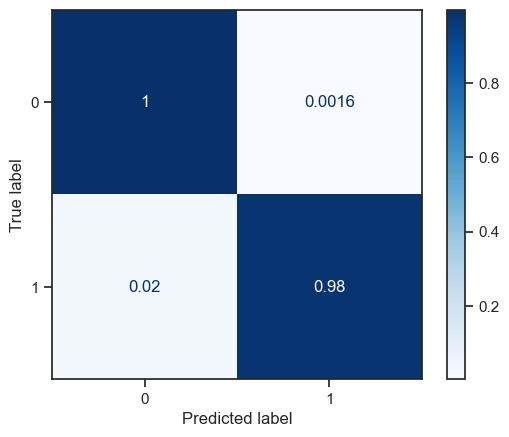

In [46]:
# Вывод матрицы ошибок
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", normalize="true")
plt.show()

In [47]:
# Значение f1-меры
f1_score(y_test, y_pred)

0.9840793030940223

## Сравнение классификаторов

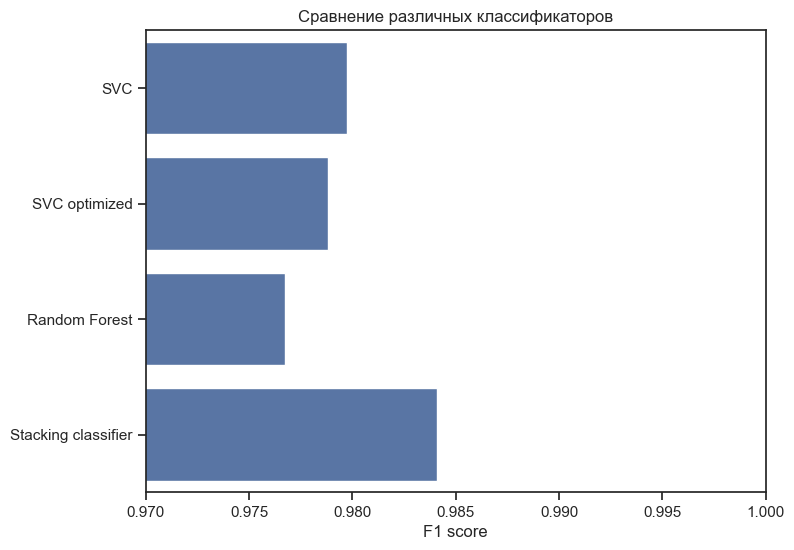

In [60]:
# Сравнение качества классификаторов
model_list = [clf_SVC, best_clf, clf_RF, stacking_clf]
model_names = ["SVC", "SVC optimized", "Random Forest", "Stacking classifier"]
f1_list = [f1_score(y_test, model.predict(X_test)) for model in model_list]

f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=f1_list, y=model_names, ax=ax)
ax.set_xlim(0.97, 1)
ax.set_xlabel("F1 score")
ax.set_title("Сравнение различных классификаторов")
plt.show()

Лучшей оказалась модель стекинга, на втором месте метод опорных векторов (без подбора гиперпараметров), на третьем — метод опорных векторов с подбором гиперпараметров. Хуже всего себя показал случайный лес.

## Submission

In [48]:
# Создание файла ответов
X_submission = test_df["url"] + " " + test_df["title"].apply(text_preprocessing)
y_submission = stacking_clf.predict(X_submission)

submission_df = pd.DataFrame({"ID": test_df.ID, "label": y_submission})
submission_df.to_csv("submission.csv", index=False)